In [ ]:
import torch
import torch.nn.functional as F
import numpy as np
import cv2
import matplotlib.pyplot as plt

from torchvision import models, transforms
import torch.nn as nn

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [ ]:
model = models.densenet121(pretrained=False)
model.classifier = nn.Linear(model.classifier.in_features, 10)

model.load_state_dict(torch.load("densenet121_cifar10_clean.pth", map_location=device))
model.to(device)
model.eval()

DenseNet(
  (features): Sequential(
    (conv0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (norm0): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu0): ReLU(inplace=True)
    (pool0): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (denseblock1): _DenseBlock(
      (denselayer1): _DenseLayer(
        (norm1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu1): ReLU(inplace=True)
        (conv1): Conv2d(64, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (norm2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu2): ReLU(inplace=True)
        (conv2): Conv2d(128, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      )
      (denselayer2): _DenseLayer(
        (norm1): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu

In [ ]:
class GradCAM:
    def __init__(self, model, target_layer):
        self.model = model
        self.gradients = None
        self.activations = None

        target_layer.register_forward_hook(self.save_activation)
        target_layer.register_backward_hook(self.save_gradient)

    def save_activation(self, module, input, output):
        self.activations = output

    def save_gradient(self, module, grad_input, grad_output):
        self.gradients = grad_output[0]

    def generate(self, input_tensor, class_idx=None):
        output = self.model(input_tensor)

        if class_idx is None:
            class_idx = output.argmax(dim=1)

        self.model.zero_grad()
        output[0, class_idx].backward()

        weights = self.gradients.mean(dim=(2, 3), keepdim=True)
        cam = (weights * self.activations).sum(dim=1)

        cam = F.relu(cam)
        cam = cam - cam.min()
        cam = cam = cam / (cam.max() + 1e-8)

        return cam.detach().cpu().numpy()[0]

In [ ]:
def preprocess(img):
    transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.5,0.5,0.5),(0.5,0.5,0.5))
    ])
    return transform(img).unsqueeze(0).to(device)

In [ ]:
idx = 42  # any index

# Clean CIFAR-10
from torchvision.datasets import CIFAR10
clean_dataset = CIFAR10(root="./data", train=False, download=True)
clean_img, label = clean_dataset[idx]

# Corrupted versions
contrast = np.load("contrast.npy")[4*10000 + idx]  # severity 5
fog = np.load("fog.npy")[4*10000 + idx]             # severity 5

In [ ]:
classes = [
    "airplane","automobile","bird","cat","deer",
    "dog","frog","horse","ship","truck"
]

In [ ]:
overlay = cv2.cvtColor(overlay, cv2.COLOR_BGR2RGB)

/usr/local/lib/python3.12/dist-packages/torch/nn/modules/module.py:1866: FutureWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  self._maybe_warn_non_full_backward_hook(args, result, grad_fn)


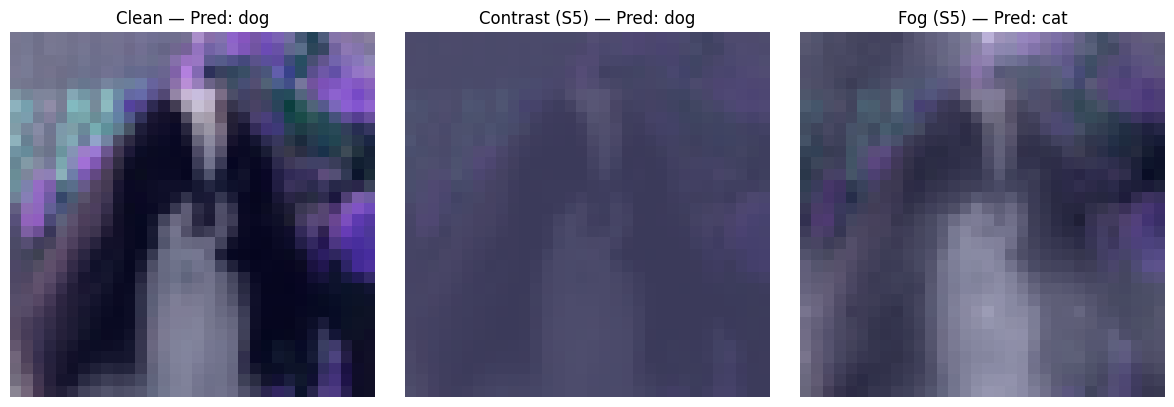

In [ ]:
target_layer = model.features[-1]
gradcam = GradCAM(model, target_layer)

images = {
    "Clean": clean_img,
    "Contrast (S5)": contrast,
    "Fog (S5)": fog
}

plt.figure(figsize=(12,4))

for i, (label, img) in enumerate(images.items()):

    # preprocess FIRST
    if isinstance(img, np.ndarray):
        input_tensor = preprocess(img)
        img_show = img_show = np.array(img).copy()
    else:
        img_np = np.array(img)
        input_tensor = preprocess(img_np)
        img_show = img_np

    # get prediction
    output = model(input_tensor)
    pred_class = classes[output.argmax(1).item()]

    # generate cam
    cam = gradcam.generate(input_tensor)

    heatmap = cv2.resize(cam, (32,32), interpolation=cv2.INTER_CUBIC)
    heatmap = np.uint8(255 * heatmap)
    heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)

    overlay = cv2.addWeighted(
    img_show.astype(np.uint8),
    0.8,   # base image dominates
    heatmap,
    0.2,   # CAM guides attention
    0
)
    overlay = cv2.cvtColor(overlay, cv2.COLOR_BGR2RGB)

    plt.subplot(1,3,i+1)
    plt.imshow(overlay.astype(np.uint8))
    plt.title(f"{label} — Pred: {pred_class}")
    plt.axis("off")

plt.tight_layout()

plt.savefig("gradcam_failures.png", dpi=300, bbox_inches='tight')

plt.show()


In [ ]:
plt.savefig("gradcam_failures.png", dpi=400, bbox_inches='tight')

<Figure size 640x480 with 0 Axes>